机器翻译与数据集

In [ ]:
import os
import torch
from d2l import torch as d2l

In [ ]:
# 下载英语-法语数据集
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

def read_data_nmt():
    """载入“英语－法语”数据集。"""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

In [ ]:
# 预处理“英语－法语”数据集
def preprocess_nmt(text):
    # 标点处理, 对于,.!?且前面没有空格的四个标点, 返回空格＋标点
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '
    # 半角全角处理
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    out = [
        ' ' + char if i > 0 and no_space(char, text[i - 1]) else char
        for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

In [ ]:
# 将数据集划分为"词元"
def tokenize_nmt(text, num_examples=None):
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

In [ ]:
# 看一下句子长度对比
d2l.set_figsize()
_, _, patches = d2l.plt.hist([[len(l)
                               for l in source], [len(l) for l in target]],
                             label=['source', 'target'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right');

In [ ]:
# 构造词汇表
# 不要小于等于2的词
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

In [ ]:
# 截断或填充文本序列, 使得序列样本都有一个固定的长度
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列。"""
    if len(line) > num_steps:
        return line[:num_steps]
    return line + [padding_token] * (num_steps - len(line))

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

In [ ]:
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量数据集用于训练"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([
        truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

In [ ]:
# 训练操作
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词汇表。"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [ ]:
# 读出“英语－法语”数据集中的第一个小批量数据#
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

编码器和解码器思想:
编码器: 把输入翻译成中间表达形式(特征)
解码器: 把中间表示解码成输出
以RNN为例:编码器, 将文本表示为向量; 解码器, 将向量表示成输出
更加抽象:

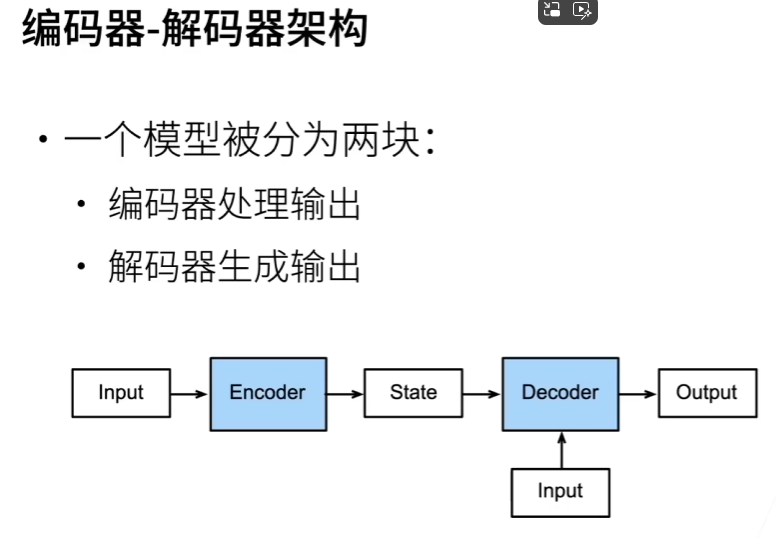

In [ ]:
# 代码实现
from torch import nn

# 给出X, 输出一个状态
class Encoder(nn.Module):
    """编码器-解码器结构的基本编码器接口。"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

In [ ]:
class Decoder(nn.Module):
    """编码器-解码器结构的基本解码器接口。"""

    #从编码器中获取输出, 额外输入, 不断更新state
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [ ]:
class EncoderDecoder(nn.Module):
    """编码器-解码器结构的基类。"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

seq2seq: 一个任意变长数据到另一个任意变长数据的转化(如翻译)
编码器是一个RNN, 输入读取句子(可以双向), 最终将一个包含句子信息的状态传给解码器
解码器使用另外一个RNN来输出

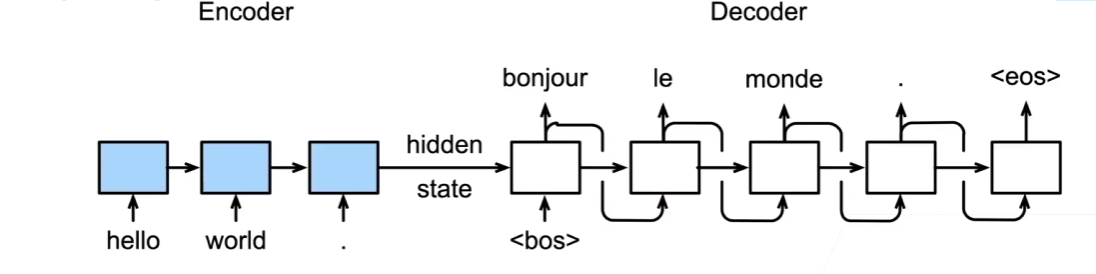

隐藏状态传递:
编码器是没有输出的RNN, 最后一层的RNN的隐藏状态, 不转化成输出, 直接传递到解码器RNN的最底层, 和解码器的embedding一起通过RNN网络, 产生最终输出
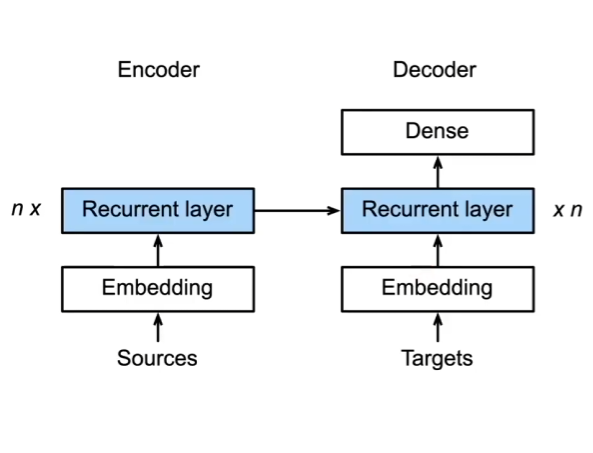

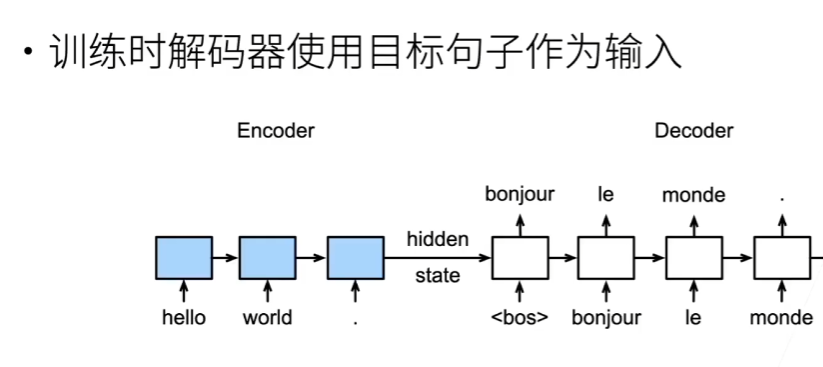

如何衡量seq2seq转换结果的好坏:
首先解释一下pn, pn就是n连词的精度, 在标签序列中出现的n连词的个数/预测数列中所有的n连词个数

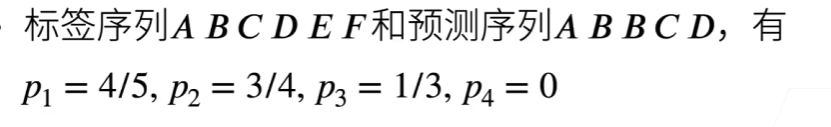

BLEU公式, 标注了该算法的核心思想:

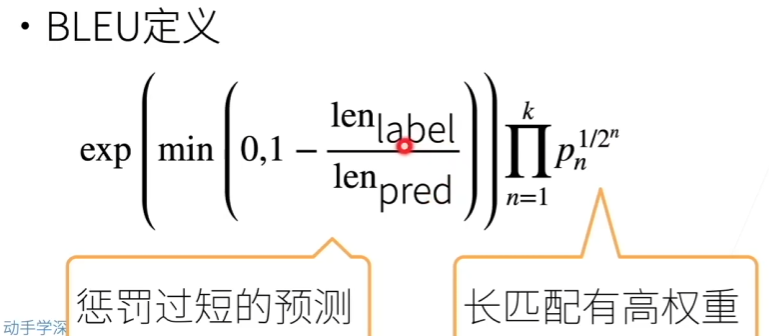

In [ ]:
# 代码实现
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
# encoder: 一个常见的RNN
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器。"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        X = self.embedding(X)
        X = X.permute(1, 0, 2)
        output, state = self.rnn(X)
        return output, state

In [ ]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape
state.shape

In [ ]:
# decoder:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器。"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        # 继承父类Decoder的初始化方法
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        # 定义嵌入层，将词索引转换为向量
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 定义GRU层：输入尺寸=嵌入维度+编码器隐藏层大小（拼接上下文），隐藏层大小和层数由参数指定
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        # 全连接层，将隐藏状态映射回词汇表维度
        self.dense = nn.Linear(num_hiddens, vocab_size)

    # 从编码器输出中提取最终的隐藏状态作为解码器初始状态（enc_outputs[1]对应编码器最后的隐藏状态）
    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # 输入X(分析目标)形状：(batch_size, seq_len) → 嵌入后→(batch_size, seq_len, embed_size)
        # permute(1,0,2)调整维度为(seq_len, batch_size, embed_size)以适应RNN输入格式
        X = self.embedding(X).permute(1, 0, 2)

        # repeat(X.shape[0], 1, 1) 将 state[-1](state[1]) 沿时间步维度复制 seq_len 次，得到 (seq_len, batch_size, num_hiddens)
        # 解码器在每个时间步都需要编码器的上下文信息（即编码器对整个输入序列的总结），因此需要将 state[-1] 复制到每个时间步
        context = state[-1].repeat(X.shape[0], 1, 1)
        # 将当前时间步的输入 X 和上下文 context 拼接在一起，作为解码器 RNN 的输入
        X_and_context = torch.cat((X, context), 2)
        # 将拼接后的输入 X_and_context 送入 GRU，计算当前时间步的输出和更新后的隐藏状态
        output, state = self.rnn(X_and_context, state)
        # 将 GRU 的输出映射到词汇表空间，并调整维度以匹配标准输出格式
        output = self.dense(output).permute(1, 0, 2)
        # 返回当前时间步的输出和更新后的隐藏状态
        return output, state

In [ ]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

In [ ]:
# musk操作: 通过零值化屏蔽不相关的项
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项。"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

# 屏蔽长于valid_len的项, 把超过valid_len的数据都置零
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

In [ ]:
# 带遮蔽的交叉熵损失函数，专门用于处理序列任务中变长序列的损失计算
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):

    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label) # 创建与标签同形状的全1权重矩阵
        weights = sequence_mask(weights, valid_len)  # 根据有效长度生成遮蔽掩码
        # 强制 CrossEntropyLoss 返回每个位置的损失值，而不是对整个批次求平均或求和
        # 便于后续根据 weights 对填充位置损失置零，再手动计算有效部分的均值
        self.reduction = 'none'
        # 输入调整: PyTorch 的 CrossEntropyLoss 要求输入形状为 (batch_size, num_classes, seq_len)
        # 而模型输出通常是 (batch_size, seq_len, num_classes)
        unweighted_loss = super(MaskedSoftmaxCELoss,
                                self).forward(pred.permute(0, 2, 1), label)
        # unweighted_loss * weights 将填充位置的损失置零，仅保留有效部分
        # mean(dim=1) 对每个样本的 ​有效序列位置​ 求平均
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [ ]:
# 代码健全性检查
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

In [ ]:
# 训练过程: 差别不大
# net: Seq2Seq 模型（包含编码器和解码器）。
# data_iter: 数据迭代器，用于生成训练批次。
# lr: 学习率。
# num_epochs: 训练轮数。
# tgt_vocab: 目标语言的词汇表（用于生成 <bos> 标记）。
# device: 计算设备（CPU/GPU）。
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    # 初始化权重（Xavier初始化）​
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    # 模型和设备配置
    net.apply(xavier_init_weights)
    net.to(device)
    # 使用Adam优化器和之前写的MaskedSoftmaxCELoss损失函数
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    # 训练循环
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    # 逐批次训练
    for epoch in range(num_epochs):
        # 计时器和动画
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)
        # 处理批次数据
        #batch 包含：
          # X: 源语言序列（形状 (batch_size, src_seq_len)）。
          # X_valid_len: 源序列的有效长度（去填充后的实际长度）。
          # Y: 目标语言序列（形状 (batch_size, tgt_seq_len)）。
          # Y_valid_len: 目标序列的有效长度。
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            # 解码器输入构造: 向解码器的输入真实目标序列
            # begin of sentence的获取
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            # # 拼接 <bos> 和 Y 的前 n-1 个词获得输入
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            # 目标序列 Y = [A, B, C, <eos>] → dec_input = [<bos>, A, B, C]

            # 前向传播
            Y_hat, _ = net(X, dec_input, X_valid_len)
            # 计算损失
            l = loss(Y_hat, Y, Y_valid_len)
            # 反向传播（计算梯度）
            l.sum().backward()
            # 梯度裁剪（防止梯度爆炸）
            d2l.grad_clipping(net, 1)
            # 记录指标
            num_tokens = Y_valid_len.sum()
            # 参数更新
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        # 可视化与日志
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    # 训练结果输出
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

In [ ]:
# 训练过程
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [ ]:
# net: 训练好的 Seq2Seq 模型（包含编码器和解码器）。
# src_sentence: 输入的源语言句子（字符串）。
# src_vocab: 源语言词汇表。
# tgt_vocab: 目标语言词汇表。
# num_steps: 解码的最大步长（防止无限循环）。
# device: 计算设备（CPU/GPU）。
# save_attention_weights: 是否保存注意力权重（用于可视化）。
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    # 设置为评估模式（禁用 Dropout）
    net.eval()
    # 处理输入句子, 小写并分词, 通过 src_vocab 将词转换为索引, 在末尾添加 <eos>（结束符）的索引
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    # 填充或截断输入序列
    enc_valid_len = torch.tensor([len(src_tokens)], device=device) # enc_valid_len: 记录输入序列的实际长度（不包括填充）
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>']) # truncate_pad: 将序列填充或截断到固定长度 num_steps
    # 编码器输入准备
    enc_X = torch.unsqueeze( # 将 src_tokens 转为 PyTorch 张量，并移动到 device
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    # 编码器前向传播
    #​输入​：enc_X: 形状 (1, num_steps) 的输入序列, enc_valid_len: 实际长度（用于遮蔽填充部分）。
    #​输出​：enc_outputs: 编码器的输出和最终隐藏状态（用于初始化解码器）
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    # 将编码器的最终隐藏状态作为解码器的初始状态
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 解码器的第一个输入是 <bos>（起始符），形状 (1, 1)（batch_size=1, seq_len=1）
    dec_X = torch.unsqueeze(
        torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device),
        dim=0)
    # 解码循环
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state) # 解码器前向传播
        dec_X = Y.argmax(dim=2) # 选择概率最高的词作为下一步输入
        pred = dec_X.squeeze(dim=0).type(torch.int32).item() # 获取预测词的索引
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights) # 保存注意力权重
        if pred == tgt_vocab['<eos>']: # 遇到结束符则停止
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq # 记录预测词

In [ ]:
def bleu(pred_seq, label_seq, k):
    """计算 BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i:i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i:i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i:i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [ ]:
# 翻译测试
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

束搜索:
起因:在seq2seq中, 我们使用贪心搜索来预测序列, 也就是说, 每一个时间步, 我们都选择最有可能的选项
由于我们的选择, 下一个时间步就会出现新的预测选项及其概率, 我们再选择概率最高的
很明显, 这样不一定会得到最优的结果

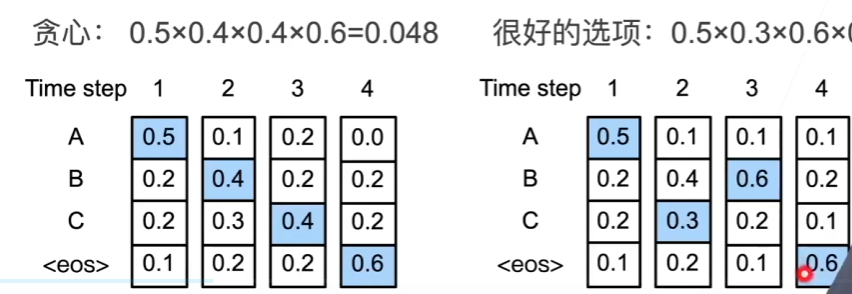

束搜索: 选择最好的k个选项进行比较
下面举一个k=2的例子:

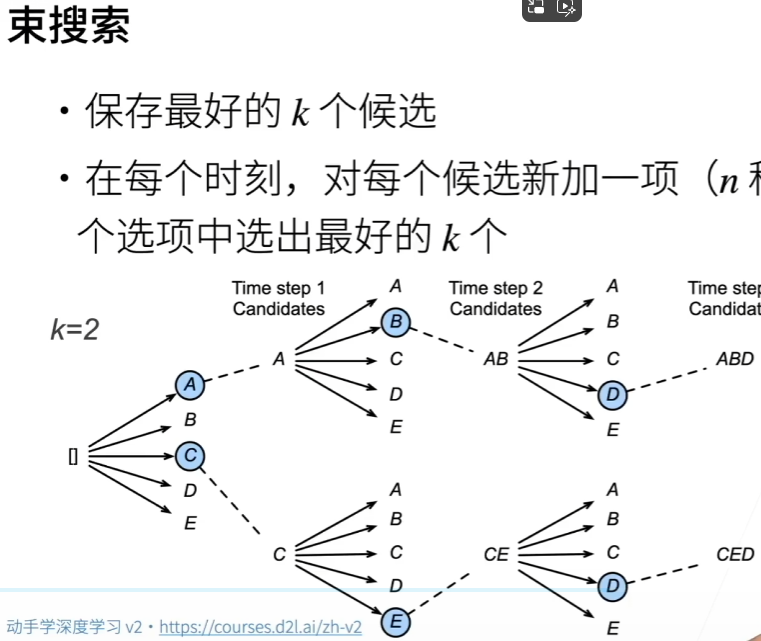

总结:
·束搜索在每次搜索时保存k个最好的候选
·k＝1时是贪心搜索
·k=n时是穷举搜索